In [2]:
from d2l import torch as d2l
import torch
import random

tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessisarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

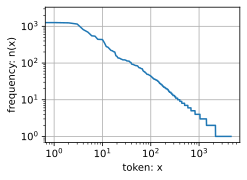

In [3]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [4]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [5]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('here', 'and', 'there'), 15),
 (('it', 'was', 'a'), 15),
 (('i', 'did', 'not'), 14),
 (('seemed', 'to', 'me'), 14),
 (('i', 'began', 'to'), 13),
 (('i', 'saw', 'the'), 13)]

In [25]:
fourgram_tokens = [quad for quad in zip(
    corpus[:-3], corpus[2:-1], corpus[3:])]
fourgram_vocab = d2l.Vocab(fourgram_tokens)
fourgram_vocab.token_freqs[:10]

[(('the', 'of', 'the'), 121),
 (('the', 'of', 'a'), 29),
 (('the', 'and', 'the'), 21),
 (('the', 'of', 'my'), 21),
 (('the', 'i', 'had'), 17),
 (('it', 'to', 'me'), 14),
 (('said', 'time', 'traveller'), 12),
 (('said', 'medical', 'man'), 11),
 (('the', 'in', 'the'), 11),
 (('and', 'i', 'had'), 10)]

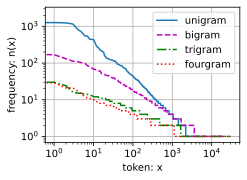

In [26]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
fourgram_freqs = [freq for token, freq in fourgram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs,fourgram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram','fourgram'])

In [7]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset to partition a sequence
    corpus = corpus[random.randint(0, num_steps):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_subseqs_per_example = num_subseqs // batch_size
    for i in range(0, batch_size * num_subseqs_per_example, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [8]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[12, 13, 14, 15, 16],
        [ 2,  3,  4,  5,  6]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [ 3,  4,  5,  6,  7]])
X:  tensor([[17, 18, 19, 20, 21],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[27, 28, 29, 30, 31],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [23, 24, 25, 26, 27]])


In [9]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X:  tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


In [11]:
class SeqDataLoader:  #@save
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [12]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab